In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
import tensorflow as tf
from pathlib import Path
from time import strftime
from shutil import rmtree
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
#matplotlib.use("TKAgg", force=True)
%matplotlib inline
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import OnlinePhotometry, SimulationParams
from rtapipe.lib.plotting.plotting import plot_sequences
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma
from rtapipe.lib.standardanalysis.li_ma import LiMa
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma, get_sigma_from_pvalue, get_sigma_for_ts_array, get_sigma_from_ts

# Loading the models

In [3]:
def load_model(model_id):
    with open("./trained_models.yaml", "r") as f:
        try:
            configs = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
    model_config = [c for c in configs["models"] if c["id"] == model_id]
    model_config = dotdict(model_config.pop())
    model_config.ad = AnomalyDetectorBuilder.getAnomalyDetector(name=model_config.name, timesteps=model_config.timesteps, nfeatures=model_config.nfeatures, load_model="True", training_epoch_dir=model_config.path, training=False)
    model_config.pvalue_table = get_pval_table(model_config.pval_path) 
    return model_config

In [4]:
model_config_cnn = load_model(0)
model_config_cnn

AnomalyDetector_cnn_l2_u32 - input shape: (5,3)


{'id': 0,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_cnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19',
 'epoch': 19,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19/pvalues/pval_20221118-113940/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_cnn.AnomalyDetector_cnn_l2_u32 at 0x2b0274c3fdc0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.003171       0.000

In [5]:
model_config_rnn = load_model(1)
model_config_rnn

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


{'id': 1,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_rnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10',
 'epoch': 10,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10/pvalues/pval_20221121-132236/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_rnn.AnomalyDetector_rnn_l2_u32 at 0x2b02785f3ca0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.000227       0.000

# Loading the test dataset

In [6]:
output_dir = "./logs/test_models_dataset_itime_5_e_out"

In [7]:
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]

In [8]:
data_manager = DataManager(output_dir)

In [9]:
dataset_id="test_itime_5_c_tsl_5_nbins_3"

In [10]:
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/test/itime_5_e/fits_data"
fits_files = DataManager.load_fits_data(dataset_folder, limit=210)
test_set_size = len(fits_files)

Loaded 188 files


In [11]:
sim_params = SimulationParams(runid=None, onset=250, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="grb")
multiple_templates = True
add_target_region = True
integration_time = 5
number_of_energy_bins = 3
tsl = 100
threads = 30
normalize = True
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(5, 100)

Loading cached data from run0002_ID000044_it_5_tsl_100.npy
Loading cached data from run0011_ID000139_it_5_tsl_100.npy
Loading cached data from run0016_ID000340_it_5_tsl_100.npy
Loading cached data from run0017_ID000132_it_5_tsl_100.npy
Loading cached data from run0017_ID000261_it_5_tsl_100.npy
Loading cached data from run0019_ID000070_it_5_tsl_100.npy
Loading cached data from run0019_ID000268_it_5_tsl_100.npy
Loading cached data from run0026_ID000127_it_5_tsl_100.npy
Loading cached data from run0029_ID000397_it_5_tsl_100.npy
Loading cached data from run0029_ID000446_it_5_tsl_100.npy
Loading cached data from run0032_ID000190_it_5_tsl_100.npy
Loading cached data from run0038_ID000228_it_5_tsl_100.npy
Loading cached data from run0043_ID000231_it_5_tsl_100.npy
Loading cached data from run0043_ID000324_it_5_tsl_100.npy
Loading cached data from run0043_ID000460_it_5_tsl_100.npy
Loading cached data from run0046_ID000029_it_5_tsl_100.npy
Loading cached data from run0046_ID000300_it_5_tsl_100.n

In [12]:
assert len(data_manager.data) == test_set_size

## Plot some samples

In [13]:
for template in list(data_manager.data.keys())[0:5]:
    data_manager.plot_timeseries(template, data_manager.data[template], 1, sim_params, output_dir, labels=features_names)

Produced: logs/test_models_dataset_itime_5_e_out/template_run0002_ID000044_trial_0_2022-12-20 18:17:15.542784.png
Saved: ./logs/test_models_dataset_itime_5_e_out/template_run0002_ID000044_trial_0_2022-12-20 18:17:15.542784.png
Produced: logs/test_models_dataset_itime_5_e_out/template_run0011_ID000139_trial_0_2022-12-20 18:17:17.825097.png
Saved: ./logs/test_models_dataset_itime_5_e_out/template_run0011_ID000139_trial_0_2022-12-20 18:17:17.825097.png
Produced: logs/test_models_dataset_itime_5_e_out/template_run0016_ID000340_trial_0_2022-12-20 18:17:20.424828.png
Saved: ./logs/test_models_dataset_itime_5_e_out/template_run0016_ID000340_trial_0_2022-12-20 18:17:20.424828.png
Produced: logs/test_models_dataset_itime_5_e_out/template_run0017_ID000132_trial_0_2022-12-20 18:17:22.799247.png
Saved: ./logs/test_models_dataset_itime_5_e_out/template_run0017_ID000132_trial_0_2022-12-20 18:17:22.799247.png
Produced: logs/test_models_dataset_itime_5_e_out/template_run0017_ID000261_trial_0_2022-12-2

# TESTING

In [14]:
data_manager.load_scaler(model_config_rnn.scaler_path) # model_config_rnn.scaler_path or model_config_cnn.scaler_path

In [15]:
test_all_x, test_all_y = data_manager.get_test_set_all_templates(verbose=False, onset=250, integration_time=integration_time, sub_window_size=5, stride=1)

[2022-12-20 18:17:28.065602] Total x shape shape: (18048, 5, 3)
[2022-12-20 18:17:28.065696] Total y shape shape: (18048,)


# RNN

## Standard metrics - 3 sigma threshold

In [16]:
SIGMA_THRESHOLD = 3

In [17]:
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.0005921241825 corresponding to 3.0060572682 sigma


In [18]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.0005921241825
accuracy 0.8507867907801419
precision 0.9983182999541355
recall 0.7088580112896222
f1 0.8290484352186885
roc_auc 0.8538065520458975
confusion_matrix [[8825, 11], [2682, 6530]]
false_positive_rate 0.0016817000458645467
detection_delay: 6.01063829787234


## Standard metrics - 5 sigma threshold

In [19]:
SIGMA_THRESHOLD = 5

In [20]:
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.0020782086315 corresponding to 5.0488536162 sigma


In [21]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.0020782086315
accuracy 0.7723847517730497
precision 0.9982428738773916
recall 0.5550369083803735
f1 0.7134086786661086
roc_auc 0.7770091739728938
confusion_matrix [[8827, 9], [4099, 5113]]
false_positive_rate 0.001757126122608356
detection_delay: 5.75


## Sigma table

In [22]:
def crop_to_5(s):
    if s > 5: 
        s = 5.00001
    return s

In [23]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_rnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_rnn.pvalue_table, model_config_rnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_rnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_rnn = sigma_table_rnn.applymap(crop_to_5)

100%|████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:13<00:00, 13.63it/s]


In [24]:
sigma_table_rnn

,run0002_ID000044,run0011_ID000139,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0019_ID000070,run0019_ID000268,run0026_ID000127,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0038_ID000228,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0046_ID000029,run0046_ID000300,run0048_ID000465,run0051_ID000166,run0051_ID000434,run0055_ID000128,run0066_ID000041,run0067_ID000395,run0076_ID000465,run0079_ID000383,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0109_ID000136,run0111_ID000027,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0130_ID000461,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0154_ID000068,run0155_ID000328,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0163_ID000414,run0173_ID000131,run0176_ID000473,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0191_ID000005,run0192_ID000017,run0192_ID000068,run0193_ID000134,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0210_ID000082,run0214_ID000101,run0218_ID000245,run0221_ID000122,run0222_ID000318,run0226_ID000257,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0240_ID000371,run0242_ID000066,run0252_ID000066,run0254_ID000456,run0258_ID000139,run0258_ID000165,run0278_ID000152,run0283_ID000065,run0284_ID000362,run0286_ID000021,run0286_ID000099,run0291_ID000001,run0294_ID000203,run0301_ID000376,run0309_ID000061,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0325_ID000165,run0339_ID000241,run0340_ID000060,run0341_ID000126,run0343_ID000134,run0344_ID000129,run0349_ID000154,run0350_ID000189,run0352_ID000076,run0354_ID000089,run0358_ID000063,run0363_ID000327,run0369_ID000392,run0370_ID000146,run0382_ID000397,run0383_ID000191,run0385_ID000009,run0395_ID000138,run0398_ID000008,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000425,run0421_ID000212,run0423_ID000024,run0428_ID000157,run0429_ID000078,run0431_ID000202,run0436_ID000045,run0444_ID000110,run0452_ID000030,run0453_ID000359,run0457_ID000240,run0459_ID000351,run0460_ID000344,run0461_ID000109,run0467_ID000192,run0478_ID000180,run0478_ID000222,run0478_ID000299,run0481_ID000384,run0493_ID000305,run0494_ID000343,run0496_ID000386,run0498_ID000059,run0498_ID000071,run0498_ID000373,run0501_ID000313,run0501_ID000398,run0508_ID000316,run0524_ID000291,run0533_ID000171,run0535_ID000181,run0556_ID000312,run0559_ID000332,run0562_ID000069,run0563_ID000044,run0569_ID000136,run0576_ID000397,run0583_ID000329,run0584_ID000213,run0586_ID000161,run0592_ID000035,run0607_ID000306,run0610_ID000260,run0615_ID000207,run0620_ID000109,run0629_ID000224,run0637_ID000089,run0641_ID000127,run0641_ID000226,run0642_ID000033,run0652_ID000307,run0655_ID000259,run0658_ID000260,run0667_ID000126,run0688_ID000044,run0697_ID000167,run0709_ID000364,run0711_ID000203,run0712_ID000163,run0722_ID000130,run0722_ID000187,run0762_ID000202,run0763_ID000224,run0765_ID000033,run0767_ID000231,run0780_ID000007,run0788_ID000236,run0792_ID000290,run0793_ID000465,run0798_ID000122,run0798_ID000403,run0799_ID000140,run0804_ID000031,run0811_ID000253,run0812_ID000337,run0839_ID000040,run0853_ID000363,run0879_ID000213,run0880_ID000380,run0881_ID000086
0-25,0.0,0,0,0,0.000000,0.00000,0.000000,0,0,0,0.0,0.000000,0,0,0.000000,0.000000,0,0,0.00000,0.000000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000

# CNN

## Standard metrics - 3 sigma

In [25]:
SIGMA_THRESHOLD = 3

In [26]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.006506945827 corresponding to 3.0286528291 sigma


In [27]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.006506945827
accuracy 0.7980385638297872
precision 0.9982101306604618
recall 0.6054059921841077
f1 0.7536995742955606
roc_auc 0.8021371291839506
confusion_matrix [[8826, 10], [3635, 5577]]
false_positive_rate 0.0017898693395382137
detection_delay: 6.537234042553192


## Standard metrics - 5 sigma

In [28]:
SIGMA_THRESHOLD = 5

In [29]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.0139048776129999 corresponding to 5.0465140766 sigma


In [30]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.0139048776129999
accuracy 0.73260195035461
precision 0.9984090909090909
recall 0.47687798523664787
f1 0.6454598883338231
roc_auc 0.7380428857826516
confusion_matrix [[8829, 7], [4819, 4393]]
false_positive_rate 0.001590909090909091
detection_delay: 5.585106382978723


## Sigma table

In [31]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_cnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_cnn.pvalue_table, model_config_cnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_cnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_cnn = sigma_table_cnn.applymap(crop_to_5)
sigma_table_cnn

100%|████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.01it/s]


,run0002_ID000044,run0011_ID000139,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0019_ID000070,run0019_ID000268,run0026_ID000127,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0038_ID000228,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0046_ID000029,run0046_ID000300,run0048_ID000465,run0051_ID000166,run0051_ID000434,run0055_ID000128,run0066_ID000041,run0067_ID000395,run0076_ID000465,run0079_ID000383,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0109_ID000136,run0111_ID000027,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0130_ID000461,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0154_ID000068,run0155_ID000328,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0163_ID000414,run0173_ID000131,run0176_ID000473,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0191_ID000005,run0192_ID000017,run0192_ID000068,run0193_ID000134,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0210_ID000082,run0214_ID000101,run0218_ID000245,run0221_ID000122,run0222_ID000318,run0226_ID000257,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0240_ID000371,run0242_ID000066,run0252_ID000066,run0254_ID000456,run0258_ID000139,run0258_ID000165,run0278_ID000152,run0283_ID000065,run0284_ID000362,run0286_ID000021,run0286_ID000099,run0291_ID000001,run0294_ID000203,run0301_ID000376,run0309_ID000061,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0325_ID000165,run0339_ID000241,run0340_ID000060,run0341_ID000126,run0343_ID000134,run0344_ID000129,run0349_ID000154,run0350_ID000189,run0352_ID000076,run0354_ID000089,run0358_ID000063,run0363_ID000327,run0369_ID000392,run0370_ID000146,run0382_ID000397,run0383_ID000191,run0385_ID000009,run0395_ID000138,run0398_ID000008,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000425,run0421_ID000212,run0423_ID000024,run0428_ID000157,run0429_ID000078,run0431_ID000202,run0436_ID000045,run0444_ID000110,run0452_ID000030,run0453_ID000359,run0457_ID000240,run0459_ID000351,run0460_ID000344,run0461_ID000109,run0467_ID000192,run0478_ID000180,run0478_ID000222,run0478_ID000299,run0481_ID000384,run0493_ID000305,run0494_ID000343,run0496_ID000386,run0498_ID000059,run0498_ID000071,run0498_ID000373,run0501_ID000313,run0501_ID000398,run0508_ID000316,run0524_ID000291,run0533_ID000171,run0535_ID000181,run0556_ID000312,run0559_ID000332,run0562_ID000069,run0563_ID000044,run0569_ID000136,run0576_ID000397,run0583_ID000329,run0584_ID000213,run0586_ID000161,run0592_ID000035,run0607_ID000306,run0610_ID000260,run0615_ID000207,run0620_ID000109,run0629_ID000224,run0637_ID000089,run0641_ID000127,run0641_ID000226,run0642_ID000033,run0652_ID000307,run0655_ID000259,run0658_ID000260,run0667_ID000126,run0688_ID000044,run0697_ID000167,run0709_ID000364,run0711_ID000203,run0712_ID000163,run0722_ID000130,run0722_ID000187,run0762_ID000202,run0763_ID000224,run0765_ID000033,run0767_ID000231,run0780_ID000007,run0788_ID000236,run0792_ID000290,run0793_ID000465,run0798_ID000122,run0798_ID000403,run0799_ID000140,run0804_ID000031,run0811_ID000253,run0812_ID000337,run0839_ID000040,run0853_ID000363,run0879_ID000213,run0880_ID000380,run0881_ID000086
0-25,0.0,0,0,0,0.000000,0.00000,0.000000,0,0,0,0.0,0.0,0,0,0,0.000000,0,0,0.000000,0.000000,0.000000,0.00000,0,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0,0.00000,0.000000,0.000000,0.00000,0.00000,0,0,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.0,0.0

In [32]:
sigma_table_cnn

,run0002_ID000044,run0011_ID000139,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0019_ID000070,run0019_ID000268,run0026_ID000127,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0038_ID000228,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0046_ID000029,run0046_ID000300,run0048_ID000465,run0051_ID000166,run0051_ID000434,run0055_ID000128,run0066_ID000041,run0067_ID000395,run0076_ID000465,run0079_ID000383,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0109_ID000136,run0111_ID000027,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0130_ID000461,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0154_ID000068,run0155_ID000328,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0163_ID000414,run0173_ID000131,run0176_ID000473,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0191_ID000005,run0192_ID000017,run0192_ID000068,run0193_ID000134,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0210_ID000082,run0214_ID000101,run0218_ID000245,run0221_ID000122,run0222_ID000318,run0226_ID000257,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0240_ID000371,run0242_ID000066,run0252_ID000066,run0254_ID000456,run0258_ID000139,run0258_ID000165,run0278_ID000152,run0283_ID000065,run0284_ID000362,run0286_ID000021,run0286_ID000099,run0291_ID000001,run0294_ID000203,run0301_ID000376,run0309_ID000061,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0325_ID000165,run0339_ID000241,run0340_ID000060,run0341_ID000126,run0343_ID000134,run0344_ID000129,run0349_ID000154,run0350_ID000189,run0352_ID000076,run0354_ID000089,run0358_ID000063,run0363_ID000327,run0369_ID000392,run0370_ID000146,run0382_ID000397,run0383_ID000191,run0385_ID000009,run0395_ID000138,run0398_ID000008,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000425,run0421_ID000212,run0423_ID000024,run0428_ID000157,run0429_ID000078,run0431_ID000202,run0436_ID000045,run0444_ID000110,run0452_ID000030,run0453_ID000359,run0457_ID000240,run0459_ID000351,run0460_ID000344,run0461_ID000109,run0467_ID000192,run0478_ID000180,run0478_ID000222,run0478_ID000299,run0481_ID000384,run0493_ID000305,run0494_ID000343,run0496_ID000386,run0498_ID000059,run0498_ID000071,run0498_ID000373,run0501_ID000313,run0501_ID000398,run0508_ID000316,run0524_ID000291,run0533_ID000171,run0535_ID000181,run0556_ID000312,run0559_ID000332,run0562_ID000069,run0563_ID000044,run0569_ID000136,run0576_ID000397,run0583_ID000329,run0584_ID000213,run0586_ID000161,run0592_ID000035,run0607_ID000306,run0610_ID000260,run0615_ID000207,run0620_ID000109,run0629_ID000224,run0637_ID000089,run0641_ID000127,run0641_ID000226,run0642_ID000033,run0652_ID000307,run0655_ID000259,run0658_ID000260,run0667_ID000126,run0688_ID000044,run0697_ID000167,run0709_ID000364,run0711_ID000203,run0712_ID000163,run0722_ID000130,run0722_ID000187,run0762_ID000202,run0763_ID000224,run0765_ID000033,run0767_ID000231,run0780_ID000007,run0788_ID000236,run0792_ID000290,run0793_ID000465,run0798_ID000122,run0798_ID000403,run0799_ID000140,run0804_ID000031,run0811_ID000253,run0812_ID000337,run0839_ID000040,run0853_ID000363,run0879_ID000213,run0880_ID000380,run0881_ID000086
0-25,0.0,0,0,0,0.000000,0.00000,0.000000,0,0,0,0.0,0.0,0,0,0,0.000000,0,0,0.000000,0.000000,0.000000,0.00000,0,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0,0.00000,0.000000,0.000000,0.00000,0.00000,0,0,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.0,0.0

# Li&Ma

In [33]:
li_ma_data = {}
#templates = list(data_manager.data.keys())
templates = []
for template in tqdm(templates):
    lima_df = LiMa.detect("binned", DataManager.get_fits_from_template(fits_files, template), temporal_bins=sigma_table_cnn.index.values, tobs=500, sigma_gt=0)
    li_ma_data[template] = lima_df["sigma"].values
lima_sigma_table = pd.DataFrame(li_ma_data, index=sigma_table_cnn.index.values)
if len(templates) > 0:
    lima_sigma_table.to_csv(Path(output_dir).joinpath("li_ma_detection_table.csv"))    

0it [00:00, ?it/s]


In [34]:
lima_sigma_table = pd.read_csv(Path(output_dir).joinpath("li_ma_detection_table.csv"), index_col=0)

In [35]:
### FIX INDEPENDENCE
for time_bin in lima_sigma_table.index:
    if int(time_bin.split("-")[1])%25 != 0:
        lima_sigma_table.loc[time_bin] = 0
lima_sigma_table

,run0002_ID000044,run0011_ID000139,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0019_ID000070,run0019_ID000268,run0026_ID000127,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0038_ID000228,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0046_ID000029,run0046_ID000300,run0048_ID000465,run0051_ID000166,run0051_ID000434,run0055_ID000128,run0066_ID000041,run0067_ID000395,run0076_ID000465,run0079_ID000383,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0109_ID000136,run0111_ID000027,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0130_ID000461,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0154_ID000068,run0155_ID000328,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0163_ID000414,run0173_ID000131,run0176_ID000473,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0191_ID000005,run0192_ID000017,run0192_ID000068,run0193_ID000134,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0210_ID000082,run0214_ID000101,run0218_ID000245,run0221_ID000122,run0222_ID000318,run0226_ID000257,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0240_ID000371,run0242_ID000066,run0252_ID000066,run0254_ID000456,run0258_ID000139,run0258_ID000165,run0278_ID000152,run0283_ID000065,run0284_ID000362,run0286_ID000021,run0286_ID000099,run0291_ID000001,run0294_ID000203,run0301_ID000376,run0309_ID000061,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0325_ID000165,run0339_ID000241,run0340_ID000060,run0341_ID000126,run0343_ID000134,run0344_ID000129,run0349_ID000154,run0350_ID000189,run0352_ID000076,run0354_ID000089,run0358_ID000063,run0363_ID000327,run0369_ID000392,run0370_ID000146,run0382_ID000397,run0383_ID000191,run0385_ID000009,run0395_ID000138,run0398_ID000008,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000425,run0421_ID000212,run0423_ID000024,run0428_ID000157,run0429_ID000078,run0431_ID000202,run0436_ID000045,run0444_ID000110,run0452_ID000030,run0453_ID000359,run0457_ID000240,run0459_ID000351,run0460_ID000344,run0461_ID000109,run0467_ID000192,run0478_ID000180,run0478_ID000222,run0478_ID000299,run0481_ID000384,run0493_ID000305,run0494_ID000343,run0496_ID000386,run0498_ID000059,run0498_ID000071,run0498_ID000373,run0501_ID000313,run0501_ID000398,run0508_ID000316,run0524_ID000291,run0533_ID000171,run0535_ID000181,run0556_ID000312,run0559_ID000332,run0562_ID000069,run0563_ID000044,run0569_ID000136,run0576_ID000397,run0583_ID000329,run0584_ID000213,run0586_ID000161,run0592_ID000035,run0607_ID000306,run0610_ID000260,run0615_ID000207,run0620_ID000109,run0629_ID000224,run0637_ID000089,run0641_ID000127,run0641_ID000226,run0642_ID000033,run0652_ID000307,run0655_ID000259,run0658_ID000260,run0667_ID000126,run0688_ID000044,run0697_ID000167,run0709_ID000364,run0711_ID000203,run0712_ID000163,run0722_ID000130,run0722_ID000187,run0762_ID000202,run0763_ID000224,run0765_ID000033,run0767_ID000231,run0780_ID000007,run0788_ID000236,run0792_ID000290,run0793_ID000465,run0798_ID000122,run0798_ID000403,run0799_ID000140,run0804_ID000031,run0811_ID000253,run0812_ID000337,run0839_ID000040,run0853_ID000363,run0879_ID000213,run0880_ID000380,run0881_ID000086
0-25,1.191668,0.386267,0.655201,0.899024,0.087820,0.523943,1.124115,0.938821,0.563853,0.762636,0.0,0.714559,0.916653,1.437177,0.072612,0.373129,1.324515,0.728540,1.209111,1.191668,3.794782,0.547521,0.296009,2.137006,0.219402,1.122566,0.84581,0.212682,0.961564,0.082668,1.093971,0.444927,0.449902,0.068412,0.236463,1.489766,0.330377,0.886052,0.955720,0.906026,1.437018,0.323109,0.406484,0.072612,0.886052,0.770952,0.077694,0.767838,0.781852,0.477587,0.460389,0.296009,1.322373,1.360710,0.585936,0.228110,2.231221,0.588033,0.071735,1.302332,1.169296,1.049634,0.076622,0.699593,0.360618,1.136672,0.296009,0.747600,0.655201,0.147182,0.713066,1.082034,0.680204,0.449902,1.259336,1.370144,0.169447,1.331144,1.209111,0.361247,0.553211,0.386267,1.518462,1.362826,1.489766,0.074058,0.290748,1.934012,1.012044,2.5

In [36]:
lima_sigma_table = lima_sigma_table.applymap(crop_to_5)
print(lima_sigma_table.shape)
print(sigma_table_rnn.shape)
lima_sigma_table.iloc[45:55]

(96, 188)
(96, 188)


,run0002_ID000044,run0011_ID000139,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0019_ID000070,run0019_ID000268,run0026_ID000127,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0038_ID000228,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0046_ID000029,run0046_ID000300,run0048_ID000465,run0051_ID000166,run0051_ID000434,run0055_ID000128,run0066_ID000041,run0067_ID000395,run0076_ID000465,run0079_ID000383,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0109_ID000136,run0111_ID000027,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0130_ID000461,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0154_ID000068,run0155_ID000328,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0163_ID000414,run0173_ID000131,run0176_ID000473,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0191_ID000005,run0192_ID000017,run0192_ID000068,run0193_ID000134,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0210_ID000082,run0214_ID000101,run0218_ID000245,run0221_ID000122,run0222_ID000318,run0226_ID000257,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0240_ID000371,run0242_ID000066,run0252_ID000066,run0254_ID000456,run0258_ID000139,run0258_ID000165,run0278_ID000152,run0283_ID000065,run0284_ID000362,run0286_ID000021,run0286_ID000099,run0291_ID000001,run0294_ID000203,run0301_ID000376,run0309_ID000061,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0325_ID000165,run0339_ID000241,run0340_ID000060,run0341_ID000126,run0343_ID000134,run0344_ID000129,run0349_ID000154,run0350_ID000189,run0352_ID000076,run0354_ID000089,run0358_ID000063,run0363_ID000327,run0369_ID000392,run0370_ID000146,run0382_ID000397,run0383_ID000191,run0385_ID000009,run0395_ID000138,run0398_ID000008,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000425,run0421_ID000212,run0423_ID000024,run0428_ID000157,run0429_ID000078,run0431_ID000202,run0436_ID000045,run0444_ID000110,run0452_ID000030,run0453_ID000359,run0457_ID000240,run0459_ID000351,run0460_ID000344,run0461_ID000109,run0467_ID000192,run0478_ID000180,run0478_ID000222,run0478_ID000299,run0481_ID000384,run0493_ID000305,run0494_ID000343,run0496_ID000386,run0498_ID000059,run0498_ID000071,run0498_ID000373,run0501_ID000313,run0501_ID000398,run0508_ID000316,run0524_ID000291,run0533_ID000171,run0535_ID000181,run0556_ID000312,run0559_ID000332,run0562_ID000069,run0563_ID000044,run0569_ID000136,run0576_ID000397,run0583_ID000329,run0584_ID000213,run0586_ID000161,run0592_ID000035,run0607_ID000306,run0610_ID000260,run0615_ID000207,run0620_ID000109,run0629_ID000224,run0637_ID000089,run0641_ID000127,run0641_ID000226,run0642_ID000033,run0652_ID000307,run0655_ID000259,run0658_ID000260,run0667_ID000126,run0688_ID000044,run0697_ID000167,run0709_ID000364,run0711_ID000203,run0712_ID000163,run0722_ID000130,run0722_ID000187,run0762_ID000202,run0763_ID000224,run0765_ID000033,run0767_ID000231,run0780_ID000007,run0788_ID000236,run0792_ID000290,run0793_ID000465,run0798_ID000122,run0798_ID000403,run0799_ID000140,run0804_ID000031,run0811_ID000253,run0812_ID000337,run0839_ID000040,run0853_ID000363,run0879_ID000213,run0880_ID000380,run0881_ID000086
225-250,1.136672,0.290748,0.817232,1.886511,0.151049,1.671923,1.204142,1.021349,2.916815,0.746287,0.000000,1.218778,0.954083,1.064616,1.126384,1.280609,1.400407,1.204142,0.803594,0.00000,0.300431,0.973858,0.485175,0.416364,1.351197,1.117652,0.00000,0.701420,0.00000,2.014259,0.152211,0.296009,0.171093,1.200407,0.068412,0.171093,0.00000,0.00000,0.682008,1.725233,1.282943,1.137326,0.644993,0.567919,0.311152,0.495605,0.074058,0.00000,0.477587,0.460389,1.761455,1.360710,0.077694,0.906026,0.65243,3.180475,1.398991,0.526634,0.064239,0.00000,0.152211,0.688925,0.000000,1.055779,0.511234,0.849613,0.410267,0.644993,0.361247,0.468219,0.625965,0.220585,0.000000,1.443828,0.372436,1.243392,0.992737,1.443828,0.201815,1.233717,0.886052,0.511234,0.080671,0.503829,0.605788,0.938821,1.024770,0.688925,0.076622,0.

## Results

In [37]:
templates_detections = dotdict({})
for templ_det in lima_sigma_table:
    templates_detections[templ_det] = dotdict({}) 
    templates_detections[templ_det]["li_ma"] = dotdict({})
    templates_detections[templ_det]["cnn"] = dotdict({})
    templates_detections[templ_det]["rnn"] = dotdict({})

In [38]:
for templ_det in lima_sigma_table:
    detections_3s = lima_sigma_table[templ_det] >= 3
    detections_5s = lima_sigma_table[templ_det] >= 5
    templates_detections[templ_det]["li_ma"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["li_ma"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["li_ma"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["li_ma"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]

for templ_det in sigma_table_rnn:
    detections_3s = sigma_table_rnn[templ_det] >= 3
    detections_5s = sigma_table_rnn[templ_det] >= 5
    templates_detections[templ_det]["rnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["rnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["rnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["rnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]
    
for templ_det in sigma_table_cnn:
    detections_3s = sigma_table_cnn[templ_det] >= 3
    detections_5s = sigma_table_cnn[templ_det] >= 5
    templates_detections[templ_det]["cnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["cnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["cnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["cnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]    

In [39]:
def get_dd(model, templates_detections, sigma, onset_index=45):
    first_detection_indexes = []
    for template_result in templates_detections.values():
        if len(template_result[model][f"{sigma}s_detections_indexes"]) > 0:
            #print(onset_index)
            #print(template_result[model][f"{sigma}s_detections_indexes"])
            first_detection_indexes.append(template_result[model][f"{sigma}s_detections_indexes"][0])
    return round((np.array(first_detection_indexes).mean()-onset_index)*integration_time,2)

In [40]:
templates_detections["run0079_ID000383"]["li_ma"][f"5s_detections_indexes"]*5

array([250, 275, 300, 325, 350, 375, 400, 425, 450, 475])

In [41]:
def get_first_detections(templates_detections, model, sigma=5):
    first_detection_indexes = []
    for template_result in templates_detections.values():
            if len(template_result[model][f"{sigma}s_detections_indexes"]) > 0:
                first_detection_indexes.append(template_result[model][f"{sigma}s_detections_indexes"][0])
    return np.array(sorted(first_detection_indexes))*5 

In [42]:
lima_first_d = get_first_detections(templates_detections, "li_ma")
ad_first_d = get_first_detections(templates_detections, "rnn")

In [43]:
lima_first_d

array([250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
       250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
       250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
       250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
       250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
       250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 275,
       275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275,
       275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275,
       275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275,
       275, 275, 275, 275, 275, 275, 275, 300, 300, 300, 300, 300, 300,
       300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 325,
       325, 325, 325, 325, 350, 350, 350, 350, 350, 375, 375, 375, 375,
       375, 400, 425, 475, 475])

In [44]:
ad_first_d

array([230, 230, 230, 230, 230, 230, 230, 230, 230, 235, 235, 235, 235,
       235, 235, 235, 235, 235, 235, 235, 235, 240, 240, 240, 240, 240,
       240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,
       240, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245,
       245, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
       250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 255, 255,
       255, 255, 255, 255, 260, 260, 260, 260, 260, 265, 265, 265, 265,
       265, 265, 265, 270, 270, 270, 270, 270, 270, 270, 275, 275, 280,
       280, 280, 285, 285, 290, 290, 295, 295, 295, 300, 300, 300, 300,
       305, 305, 310, 315, 320, 325, 325, 330, 335, 335, 340, 340, 345,
       345, 345, 350, 360, 375, 385, 410, 410, 415, 420, 430, 450, 455])

In [45]:
bins = [i for i in range(0,500,5)]

161 143


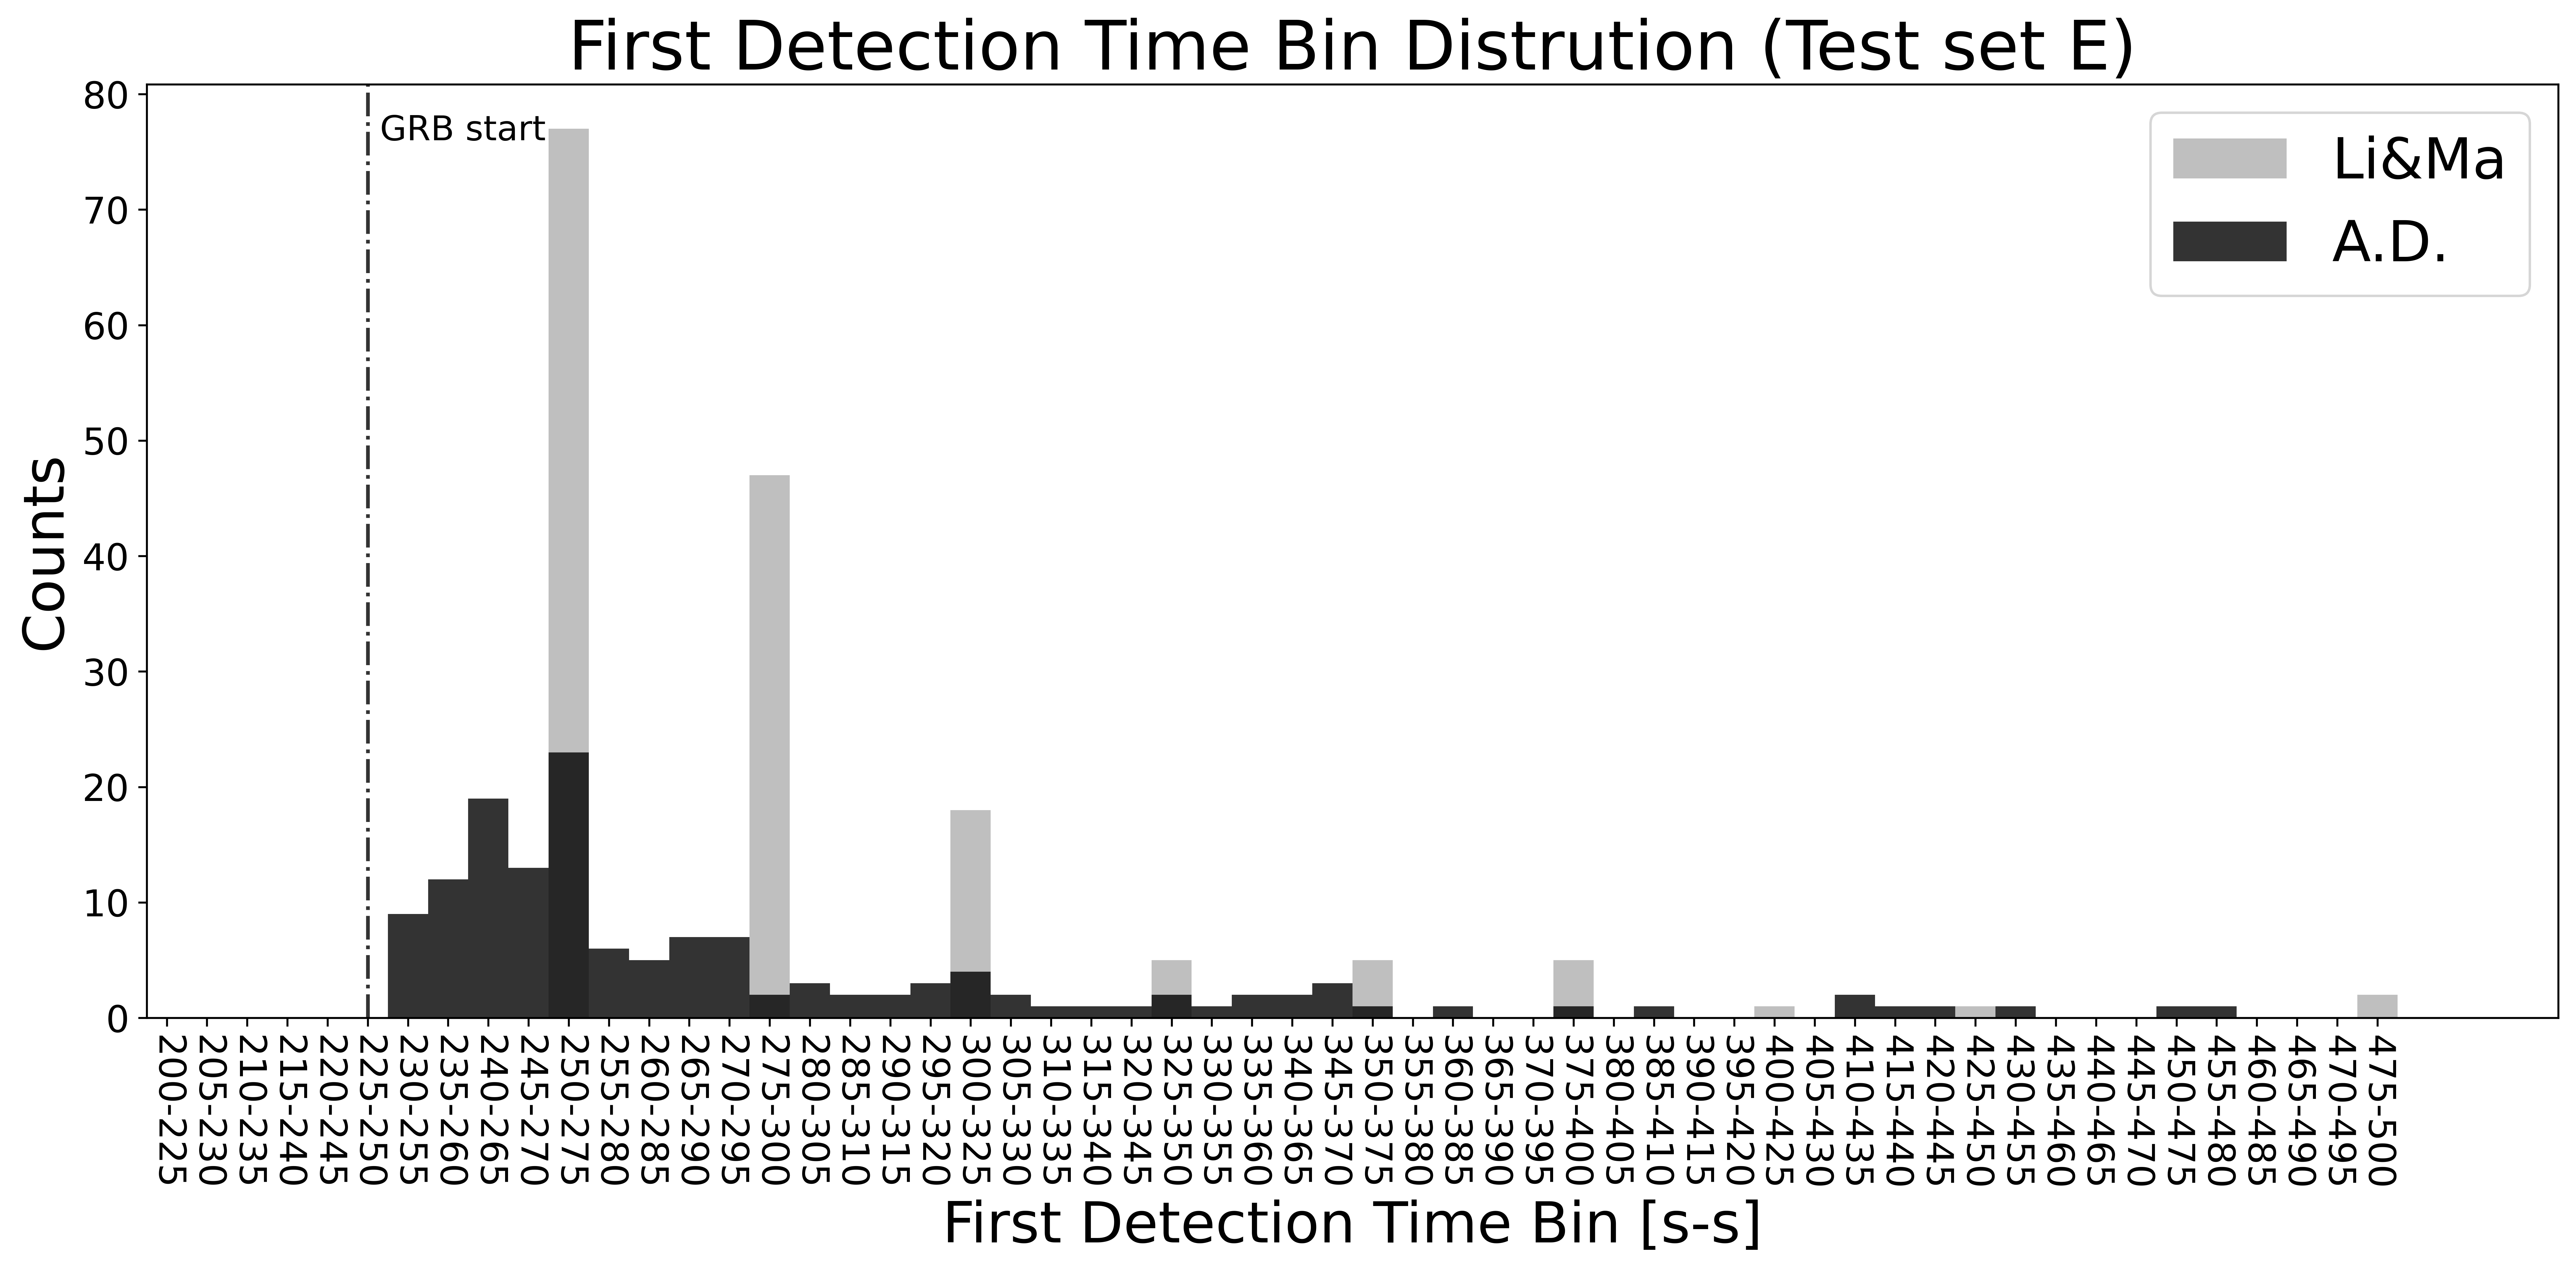

In [46]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
pc = PlotConfig()
fig, ax = plt.subplots(1,1,figsize=pc.fig_size)
print(len(lima_first_d), len(ad_first_d))

counts_li_ma, bins_li_ma = np.histogram(lima_first_d, bins=bins)
#ax.stairs(counts_li_ma, bins_li_ma, label="Li&Ma", color="grey", alpha=0.5)
ax.hist(bins_li_ma[:-1], bins_li_ma, weights=counts_li_ma, label="Li&Ma", color="grey", alpha=0.5)

counts_ad, bins_ad = np.histogram(ad_first_d, bins=bins)
#ax.stairs(counts_ad, bins_ad, label="A.D.", color="black", alpha=0.8)
ax.hist(bins_ad[:-1], bins_ad, weights=counts_ad, label="A.D.", color="black", alpha=0.8)

#counts_li_ma, bins_li_ma = ax.hist((np.array(lima_first_d))*5, label="Li&Ma", color="grey", alpha=0.5, bins=100)
#counts_ad, bins_ad       = ax.hist((np.array(ad_first_d))*5, label="A.D.", color="black", alpha=0.8, bins=100)


fig.suptitle("")

#ax.set_xlim(5,50)
ax.set_ylabel("Counts")
ax.set_xlabel("First Detection Time Bin [s-s]")
ax.legend()
ax.set_title("First Detection Time Bin Distrution (Test set E)")
ax.set_xticks([i*5 +12.5 for i in range(38,94)],sigma_table_rnn.index.values[40:], fontsize=10)
ax.axvline(x = 227.5, color='black', linestyle="-.", alpha=0.8, label="GRB start")
ax.text(229, 76, 'GRB start', fontsize = 14, color="black")
for tick in ax.get_xticklabels():
    tick.set_rotation(-90)

ax.set_xlim(200, 500)

ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()
fig.savefig(Path(output_dir).joinpath(f"ad_vs_li_ma_first_detections_testset_e_id_1.png"), dpi=pc.dpi)

In [47]:
bins_li_ma

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385,
       390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450,
       455, 460, 465, 470, 475, 480, 485, 490, 495])

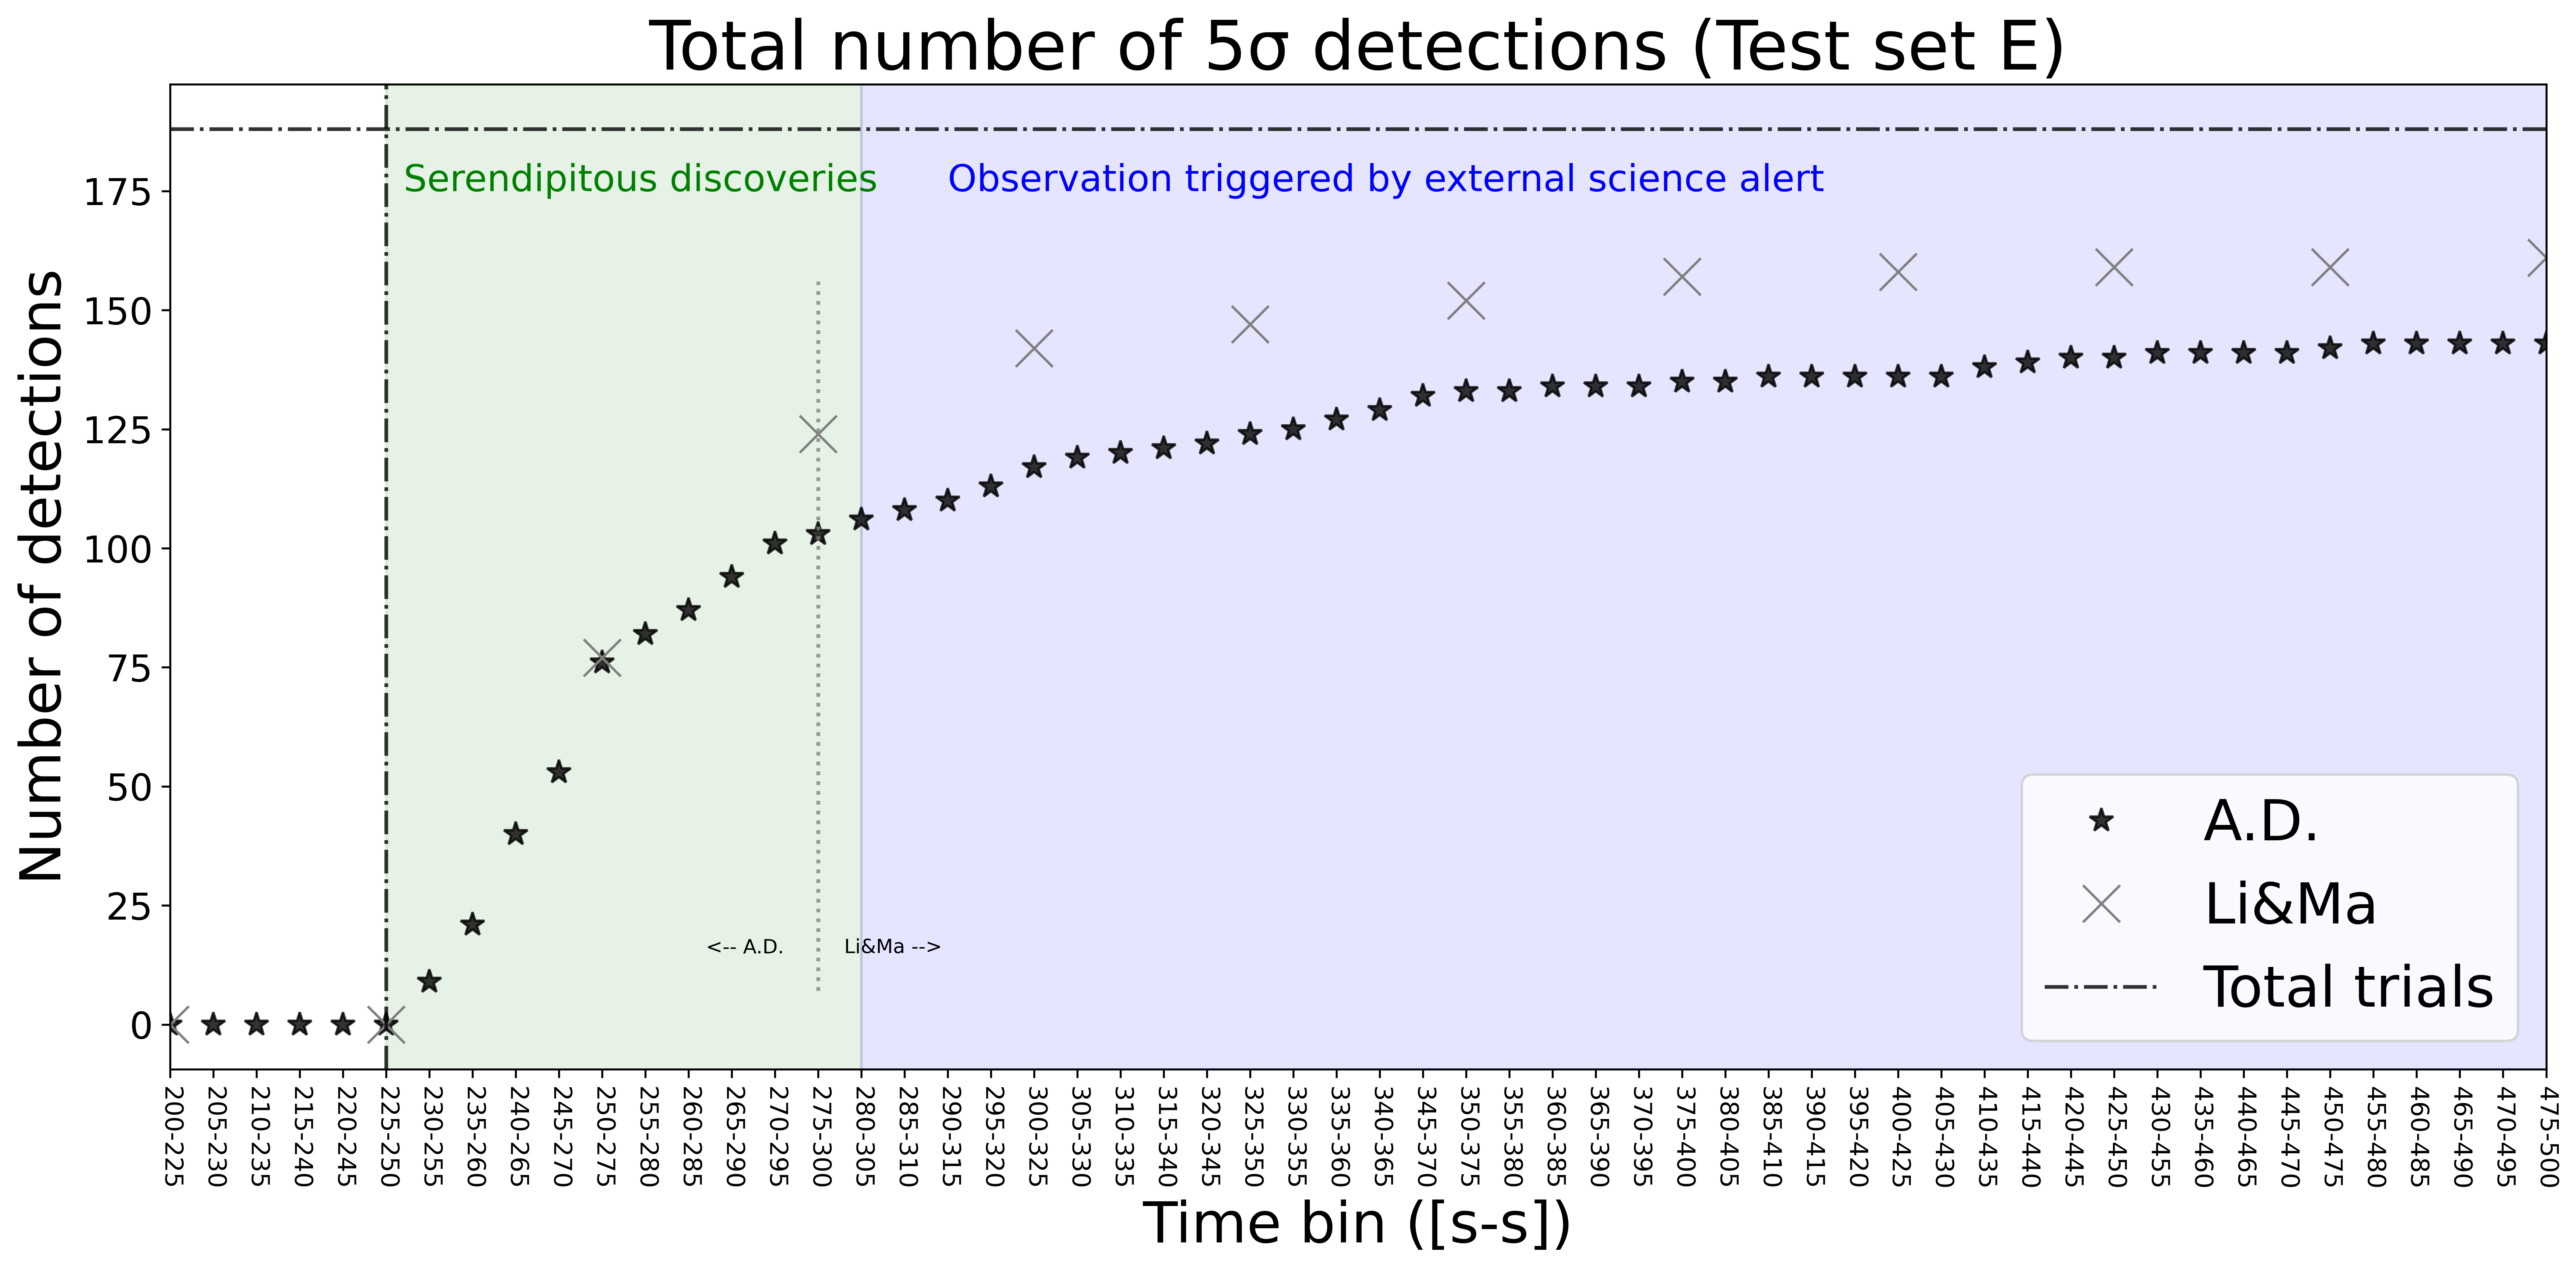

In [48]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
pc = PlotConfig()
fig, ax = plt.subplots(1,1,figsize=pc.fig_size)

cumulative_ad = np.cumsum(counts_ad)
ax.plot(bins_ad[:-1], cumulative_ad, marker="*", markersize=10, linestyle="none", label="A.D.", color="black", alpha=0.8)

cumulative_li_ma = np.cumsum(counts_li_ma)
cumulative_li_ma_reduced = []
bins_li_ma_reduced = []
for i in range(10, 100, 5):
    if i % 5 == 0:
        cumulative_li_ma_reduced.append(cumulative_li_ma[i])
        bins_li_ma_reduced.append(bins_li_ma[i])
ax.plot(bins_li_ma_reduced, cumulative_li_ma_reduced, marker="x", markersize=15, linestyle="none", label="Li&Ma", color="grey", alpha=1)

fig.suptitle("")
ax.set_ylabel("Number of detections")
ax.set_xlabel("Time bin ([s-s])")
ax.set_title("Cumulative number of 5σ detections (Test set E)")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim(200, 475)
ax.set_xticks([i*5 for i in range(40,96)],sigma_table_rnn.index.values[40:], fontsize=10)

for tick in ax.get_xticklabels():
    tick.set_rotation(-90)

ax.axvline(x = 225, color='black', linestyle="-.", alpha=0.8)    

    
ax.axvline(x = 275, color='grey', linestyle="dotted", alpha=0.8, ymin=0.08, ymax=0.8)    
ax.text(262, 15, '<-- A.D.', color='black', fontsize = 8)
ax.text(278, 15, 'Li&Ma -->', color='black', fontsize = 8)


#ax.text(227, 140, 'GRB start', fontsize = 14, color="red")
ax.axvspan(225, 280, color='green', alpha=0.1)
ax.text(227, 175, 'Serendipitous discoveries', color='green', fontsize = 15)
ax.axvspan(280, 500, color='blue', alpha=0.1)
ax.text(290, 175, 'Observation triggered by external science alert', color='blue', fontsize = 15)

ax.axhline(y = 188, color='black', linestyle="-.", alpha=0.8, label="Total trials")    

ax.legend()

fig.tight_layout()
fig.savefig(Path(output_dir).joinpath(f"ad_vs_li_cumulative_testset_e_id_1.png"), dpi=pc.dpi)

### 3 sigma detections

In [49]:
print(f'Detected by CNN: {np.array([template_result["cnn"]["3s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("cnn",templates_detections, 3)} s')
print(f'Detected by RNN: {np.array([template_result["rnn"]["3s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("rnn",templates_detections, 3)} s')
print(f'Detected by Li&Ma: {np.array([template_result["li_ma"]["3s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("li_ma",templates_detections, 3)} s')

Detected by CNN: 157 - dd: 49.62 s
Detected by RNN: 170 - dd: 42.74 s
Detected by Li&Ma: 175 - dd: 41.14 s


In [50]:
count_rnn = 0
for template_result in templates_detections.values():
    if template_result["rnn"]["3s_detection"] and not template_result["li_ma"]["3s_detection"]:
        count_rnn += 1
print(f"Detected by RNN but not by Li&Ma: {count_rnn}")

Detected by RNN but not by Li&Ma: 2


In [51]:
count_rnn = 0
for template_result in templates_detections.values():
    if not template_result["rnn"]["3s_detection"] and template_result["li_ma"]["3s_detection"]:
        count_rnn += 1
print(f"Detected by Li&Ma but not by RNN: {count_rnn}")

Detected by Li&Ma but not by RNN: 7


### 5 sigma detections

In [52]:
def get_detections_in_time(templates_detections, model):
    first_detection_indexes = []
    for template_result in templates_detections.values():
        if len(template_result["li_ma"][f"5s_detections_indexes"]) > 0:
            first_detection_indexes.append(template_result["li_ma"][f"5s_detections_indexes"][0])
    detection_time = (np.array(first_detection_indexes)-45)*integration_time
    dt_filterd = [dt for dt in detection_time if dt <= 50]
    return len(dt_filterd)

print(get_detections_in_time(templates_detections, "li_ma"))

124


In [53]:
print(f'Detected by CNN: {np.array([template_result["cnn"]["5s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("cnn",templates_detections, 5)} s')
print(f'Detected by RNN: {np.array([template_result["rnn"]["5s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("rnn",templates_detections, 5)} s')
print(f'Detected by Li&Ma: {np.array([template_result["li_ma"]["5s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("li_ma",templates_detections, 5)} s')

Detected by CNN: 128 - dd: 50.74 s
Detected by RNN: 143 - dd: 47.48 s
Detected by Li&Ma: 161 - dd: 52.02 s


In [57]:
count_cnn = 0
for template_result in templates_detections.values():
    if template_result["cnn"]["5s_detection"] and not template_result["li_ma"]["5s_detection"]:
        count_cnn += 1
print(f"Detected by CNN but not by Li&Ma: {count_cnn}")

Detected by CNN but not by Li&Ma: 0


In [54]:
count_rnn = 0
for template_result in templates_detections.values():
    if template_result["rnn"]["5s_detection"] and not template_result["li_ma"]["5s_detection"]:
        count_rnn += 1
print(f"Detected by RNN but not by Li&Ma: {count_rnn}")

Detected by RNN but not by Li&Ma: 1


In [55]:
count_rnn = 0
for template_result in templates_detections.values():
    if not template_result["rnn"]["5s_detection"] and template_result["li_ma"]["5s_detection"]:
        count_rnn += 1
print(f"Detected by Li&Ma but not by RNN: {count_rnn}")

Detected by Li&Ma but not by RNN: 19


### Sigma plots RNN vs Li&Ma

In [56]:
matplotlib.use("TKAgg", force=True)
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig

def sigma_plot(template, sigma_table_model, lima_sigma_table):
    pc = PlotConfig()    
    fig, ax = plt.subplots(1,1, figsize=pc.fig_size)
    ax.plot(sigma_table_model.index.values, sigma_table_model[template], marker='o', linestyle='--', label="Anomaly Detection", zorder=1)
    

    cumulative_li_ma_reduced = []
    bins_li_ma_reduced = []
    for i in range(10, 100, 5):
        if i % 5 == 0:
            cumulative_li_ma_reduced.append(lima_sigma_table[template][i])
            bins_li_ma_reduced.append(sigma_table_model.index.values[i])

    ax.scatter(bins_li_ma_reduced, cumulative_li_ma_reduced, marker='x', s=200, label="Li&Ma", color="grey", zorder=10)
    ax.tick_params(axis='y', labelsize=15, width=2, grid_alpha=0.5)
    ax.tick_params(axis='x', which='major', labelsize=10)
    fig.suptitle("Detection plot")
    ax.set_title(f"Template {template}")
    ax.set_ylabel("Sigma")
    ax.set_xlabel("Timeseries")
    ax.set_ylim(0, 10)
    plt.axvline(x = 45, color = 'grey', linestyle="-.")
    plt.axhline(y = 3, color = 'orange', linestyle="-.")
    plt.axhline(y = 5, color = 'red', linestyle="-.")
    mask = [True if i%2==0 else False for i in range(len(sigma_table_model.index.values))]
    ax.set_xticks(range(0, len(sigma_table_model.index.values), 2), sigma_table_model.index.values[mask], rotation=45)
    ax.legend()
    fig.savefig(Path(output_dir).joinpath(f"detection_plot_{template}_testset_e.png"), dpi=100)
    #plt.show()    
    plt.close()
templates = list(data_manager.data.keys())
    
for template in tqdm(templates):
    sigma_plot(template, sigma_table_rnn, lima_sigma_table)

100%|████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:42<00:00,  4.45it/s]
